## Table Transformer: inference notebook

In this notebook, we are going to run the Table Transformer - which is actually a [DETR](https://arxiv.org/abs/2005.12872) model - by Microsoft Research (which is part of 🤗 Transformers) to perform table detection and table structure recognition on documents.

### Quick intro: DETR
DETR is short for DEtection TRansformer, and consists of a convolutional backbone (ResNet-50 or ResNet-101) followed by an encoder-decoder Transformer. It can be trained end-to-end to perform object detection (and panoptic segmentation, for that see my other notebooks in my repo [Transformers-tutorials](https://github.com/NielsRogge/Transformers-Tutorials)).The main contribution of DETR is its simplicity: compared to other models like Faster R-CNN and Mask R-CNN, which rely on several highly engineered things like region proposals, non-maximum suppression procedure and anchor generation, DETR is a model that can simply be trained end-to-end, and fine-tuned just like you would fine-tune BERT. This is possible due to the use of a clever loss function, the so-called **bipartite matching loss**. I highly recommend [Yannic Kilcher's video](https://www.youtube.com/watch?v=T35ba_VXkMY&t=1693s) if you want to understand how the full model works.

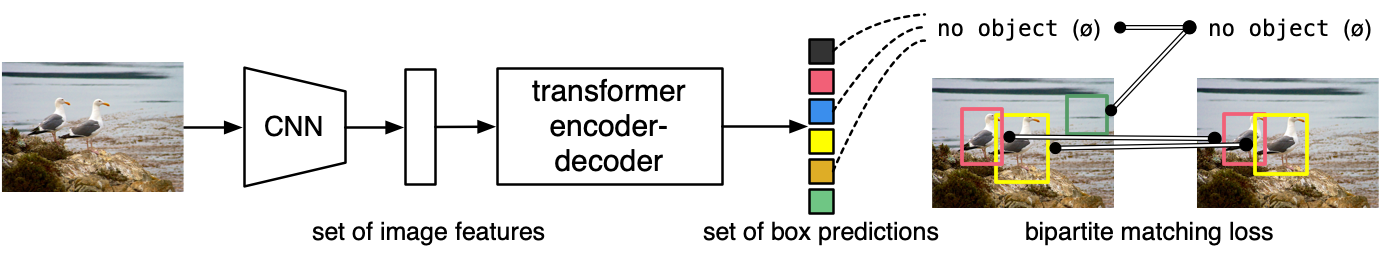

* Table Transformer paper: https://arxiv.org/abs/2110.00061
* DETR Paper: https://arxiv.org/abs/2005.12872
* DETR Blog post: https://ai.facebook.com/blog/end-to-end-object-detection-with-transformers/
* Official Github repository: https://github.com/facebookresearch/detr

My other DETR notebooks (which showcase how you can fine-tune DETR on a custom dataset, both for object detection and panoptic segmentation) can be found [here](https://github.com/NielsRogge/Transformers-Tutorials/tree/master/DETR).


## 0. Path

In [ ]:
%pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
%pip install -q timm

In [ ]:
p = Path('./samples/')

In [ ]:
str(p)

In [ ]:
p.is_dir

In [ ]:
q = p / 'do-0002.pdf'



In [ ]:
q

In [ ]:
str(q)

In [ ]:
q.resolve()

In [ ]:
p = Path('./samples/')
[x for x in p.iterdir() if x.is_dir()]

In [ ]:
p = Path('.')
[x for x in p.iterdir() if x.is_dir()]

### testes pathlib

In [ ]:
import os
os.name

Path('./samples/do-0002.pdf')



In [ ]:
list(p.glob('**/*.pdf'))


In [ ]:
from pathlib import PurePath

In [ ]:
from pathlib import PureWindowsPath

In [ ]:
import os
p = PureWindowsPath('\samples')
os.fspath(p)

In [ ]:
str(p)

In [ ]:
p = PurePath('/etc')
str(p)

p = PureWindowsPath('c:/Program Files')
str(p)


## 1. Table detection

Table detection is the task of - you guessed it - detect tables in document images, like PDFs.

Let's load a PDF and see how our model does.

In [ ]:
from pathlib import Path
from pathlib import WindowsPath

In [ ]:
wp = WindowsPath('./PDF_samples/do-01764.pdf')
wp

In [ ]:
wp = WindowsPath('./PDF_samples/do-01773.pdf')
wp

### testes image

In [ ]:
# Yes!!!!!
from pdf2image import convert_from_path

#PDF_file = 'do-0002.pdf'

PDF_file = wp

pages = convert_from_path(PDF_file, 500,userpw='01Apr!1126')

image_counter = 1

for page in pages:
    filename = "PDF_samples/PDF_pages/page_" + str(image_counter) + ".jpg"
    page.save(filename, 'JPEG')
    image_counter = image_counter + 1

In [1]:
from PIL import Image

In [2]:
Image_file = "PDF_samples/PDF_pages/page_2.jpg"

In [ ]:
Image_file = "samples/page_3.jpg"

In [ ]:
Image_file = "samples/page_4.jpg"

In [ ]:
Image_file = "samples/page_5.jpg"

In [ ]:
Image_file = "samples/page_6.jpg"

In [ ]:
Image_file = "samples/page_7.jpg"

In [ ]:
Image_file = "samples/page_8.jpg"

In [ ]:
Image_file = "samples/page_9.jpg"

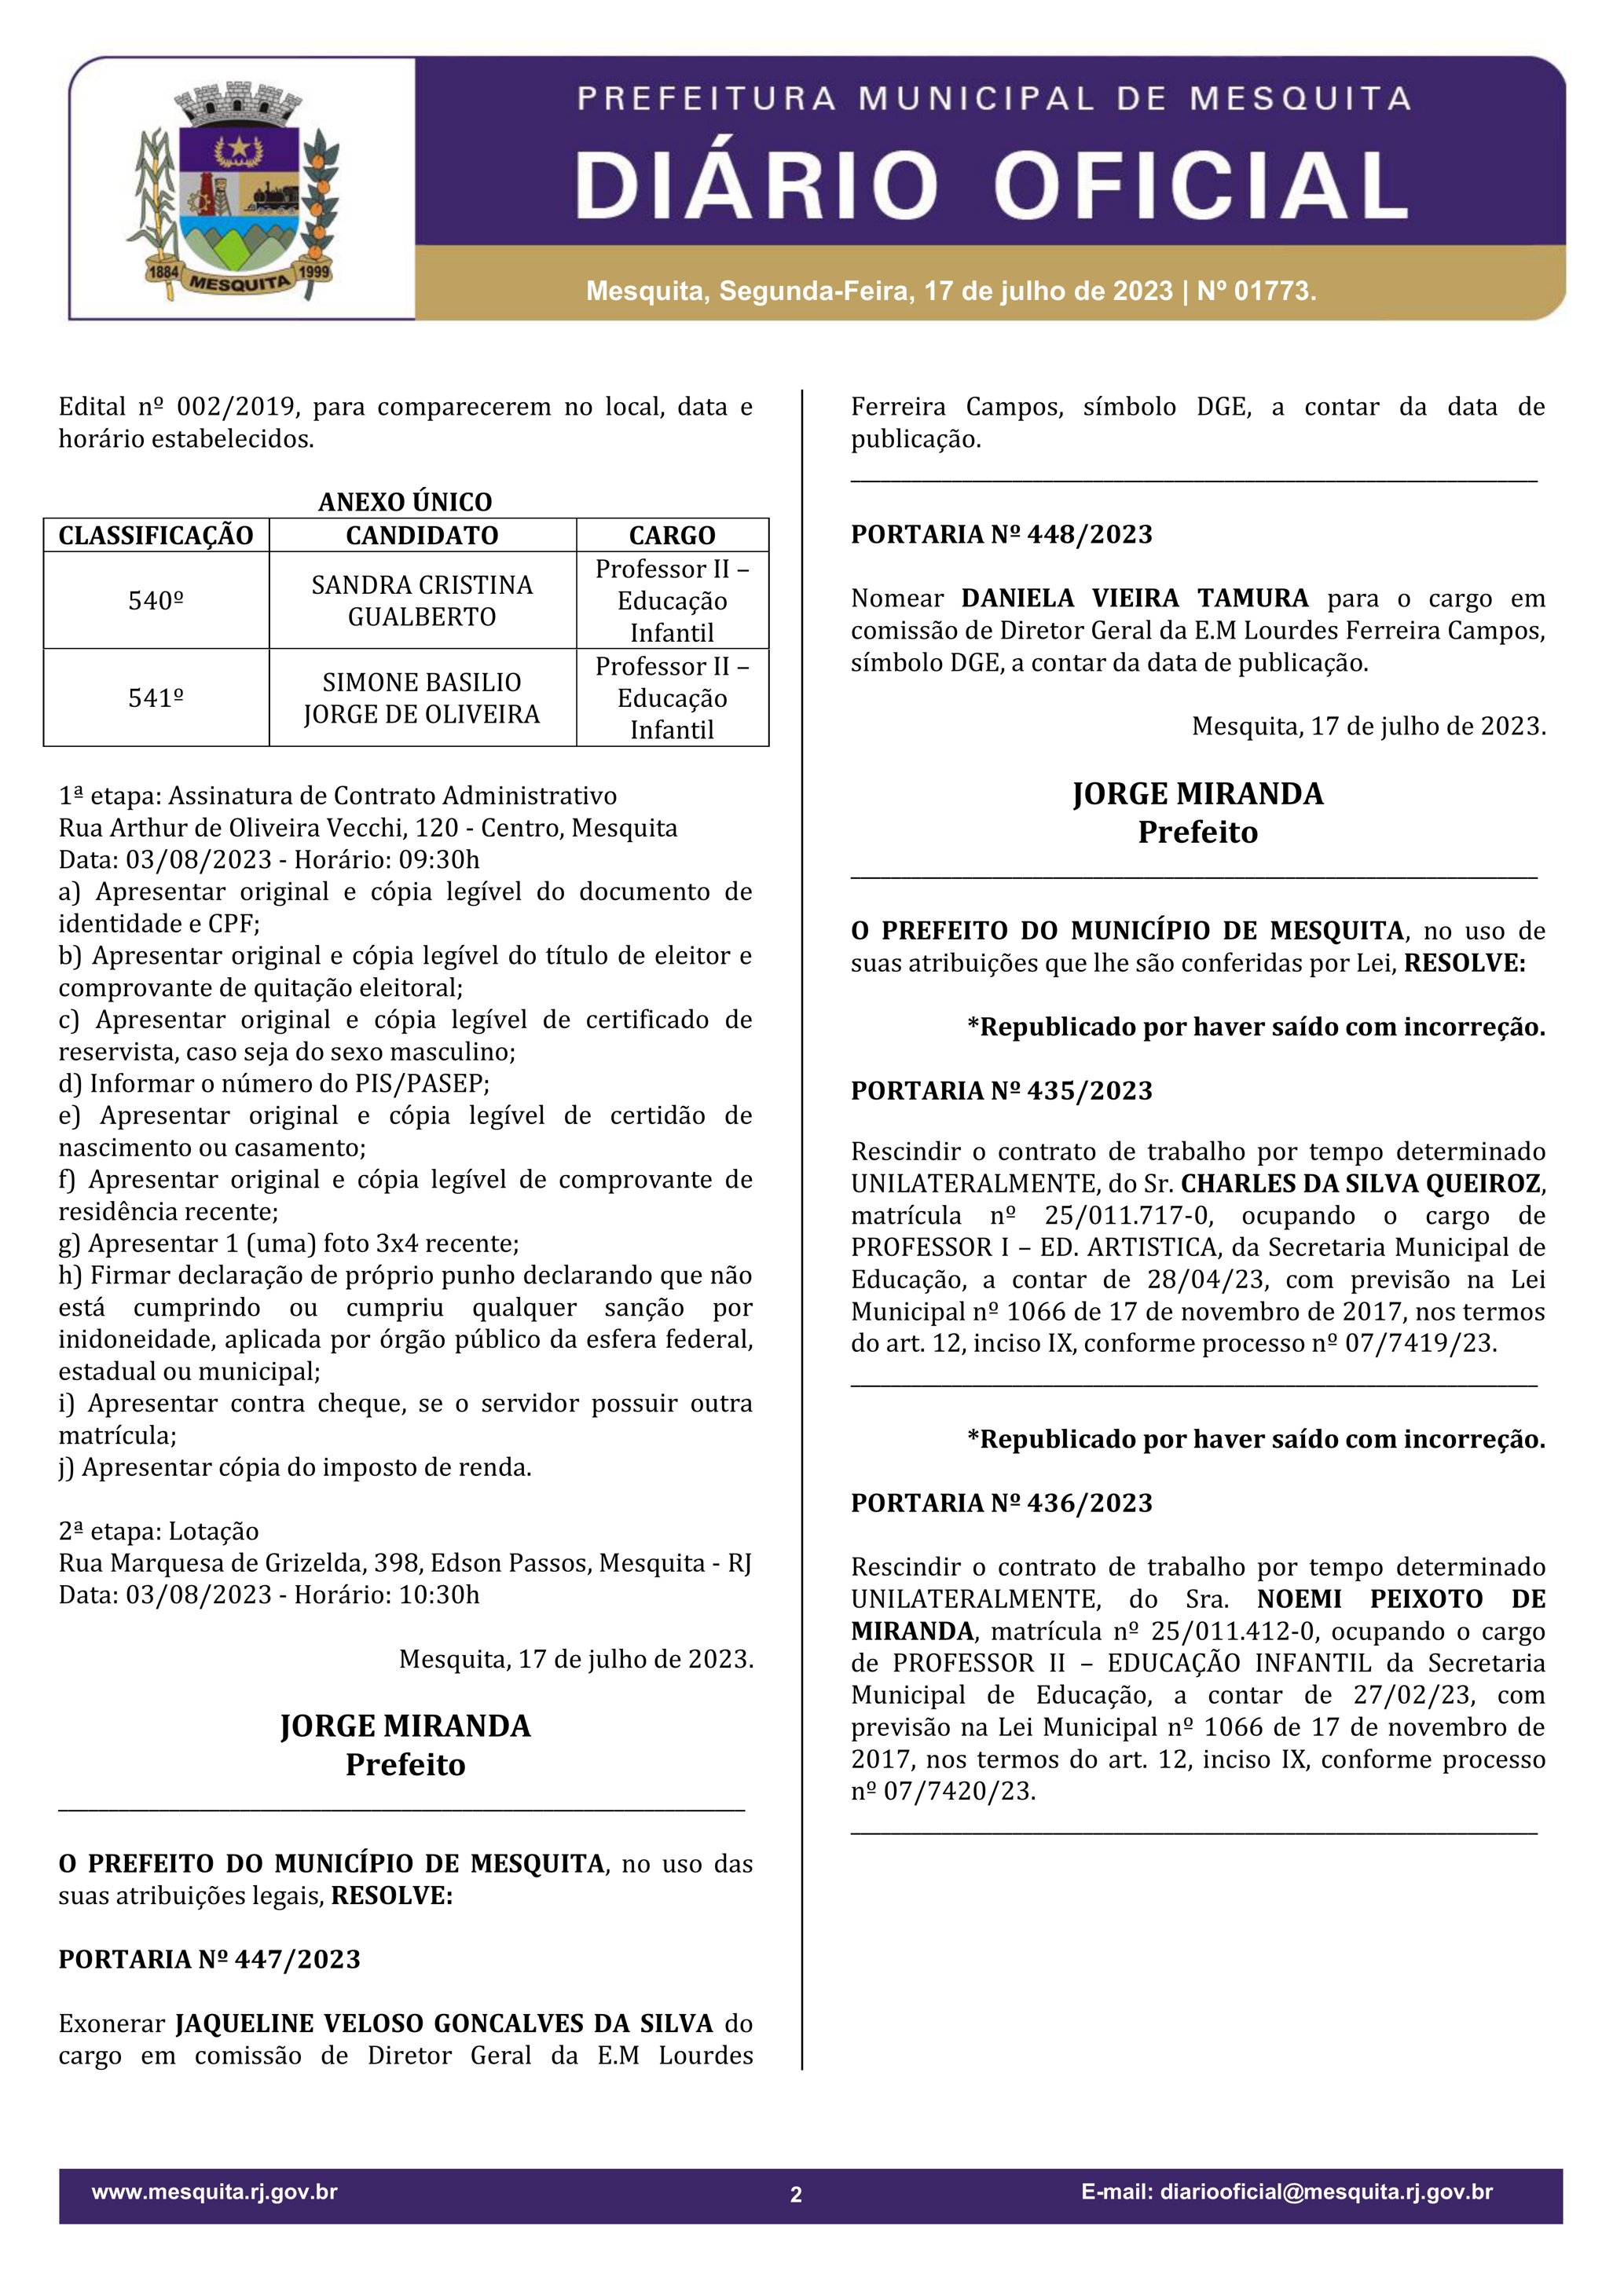

In [3]:
file_path = Image_file
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's first apply the regular image preprocessing using `DetrFeatureExtractor`. The feature extractor will resize the image (minimum size = 800, max size = 1333), and normalize it across the channels using the ImageNet mean and standard deviation.

In [4]:
from transformers import DetrImageProcessor

feature_extractor = DetrImageProcessor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [5]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1131, 800])


## Forward pass

Next, let's send the pixel values and pixel mask through the model. We first load the model from the hub, and perform a forward pass.

In [6]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

In [7]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

In [ ]:
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt

In [9]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [10]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

In [11]:
results['scores']

tensor([0.9990])

In [12]:
results['labels']

tensor([0])

In [13]:
results['boxes']

tensor([[ 141.3973, 1263.2380, 1881.5811, 1883.8478]])

In [14]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

: 

: 

Cool! Seems like our model has correctly identified the single table present in the PDF.

## Table structure recognition

Table structure recognition is the task of identifying the several rows, columns, cells in a table.

Let's load a demo table (which I took from the [paper](https://openaccess.thecvf.com/content/CVPR2022/html/Smock_PubTables-1M_Towards_Comprehensive_Table_Extraction_From_Unstructured_Documents_CVPR_2022_paper.html)) and see how our model does.

In [ ]:
file_path = "box3.png"

In [ ]:
file_path = "box4.png"

In [ ]:
file_path = "box5.png"

In [ ]:
file_path = "box6.png"

In [ ]:
file_path = "box7.png"

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image


image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

Let's prepare the image for the model using `DetrFeatureExtractor`.

In [ ]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

Let's load the model from the hub, and perform a forward pass.

In [ ]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

In [ ]:
with torch.no_grad():
  outputs = model(**encoding)

Let's visualize the results!

In [ ]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [ ]:
model.config.id2label

### Using Thinker

In [ ]:

from pdf2image import convert_from_path
from tkinter import *
from tkinter import messagebox
 
 
def pdf2img():
    try:
        images = convert_from_path(str(e1.get()))
        for img in images:
            img.save('new_folder\output.jpg', 'JPEG')
 
    except  :
        Result = "NO pdf found"
        messagebox.showinfo("Result", Result)
 
    else:
        Result = "success"
        messagebox.showinfo("Result", Result)
 
 
 
master = Tk()
Label(master, text="File Location").grid(row=0, sticky=W)
 
e1 = Entry(master)
e1.grid(row=0, column=1)
 
b = Button(master, text="Convert", command=pdf2img)
b.grid(row=0, column=2,columnspan=2, rowspan=2,padx=5, pady=5)
  
mainloop()